_This notebook is part of the material for the [Active Training Course "Advanced Deep Learning"](https://indico.desy.de/event/37478/)_

## Generating LHC data with Transformers

#### Background

Simulations for LHC physics is a major computational task at the experiment, and will become more computationally intensive in the coming years, so if ML techniques can speed up some aspects of this then it would be very useful. The process we are studying is Drell-Yan: $pp\rightarrow Z\rightarrow \mu\mu$

#### Interesting papers

- Jet Diffusion versus JetGPT — Modern Networks for the LHC<br>
  *Anja Butter, Nathan Huetsch, Sofia Palacios Schweitzer, Tilman Plehn, Peter Sorrenson, and Jonas Spinner*<br>
  https://arxiv.org/pdf/2305.10475.pdf
- Denoising Diffusion Probabilistic Models<br>
  *Jonathan Ho, Ajay Jain, Pieter Abbeel*<br>
  https://arxiv.org/pdf/2006.11239.pdf

#### Outline
- Imports
- Toy example for attention
- Loading the data and preprocessing
- Building a generative transformer step by step
- Training the model
- Generating samples
- Study the results
- Bonus exercises

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.distributions as D
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
# datapath when not using COLAB
path = "datasets/"

In [2]:
if torch.cuda.is_available():
    torch.set_default_device("cuda")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

### Toy example for attention

Before we start building a generative transformer for the LHC data from the last tutorial, we will take a look at the attention mechanism itself for a toy example. This part of the tutorial is based on Lukas Heinrich's example transformer from the MITP school 2023 "Machine Learning in Particle Theory".

#### Exercise 1: Toy attention

We will use attention to build a classifier to find out whether there are more 4s than 2s in a sequence of integers from 0 to 9. This allows us to visualize the attention matrix and values and understand what the attention mechanism is doing in this simple example.

Complete the attention mechanism in the `ToyAttention` class below. Hint: the function `torch.einsum` makes it easy to translate the equations from the lecture into PyTorch code.

In [3]:
def generate_data(batch_size):
    x = torch.randint(0,10, size=(batch_size, 10))
    count_2 = torch.count_nonzero(x == 2, dim=-1)
    count_4 = torch.count_nonzero(x == 4, dim=-1)
    return x, (count_4 > count_2).reshape(-1,1).float()

In [43]:
class ToyAttention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.query = torch.nn.Parameter(torch.randn(1,16))
        self.embedding_func = torch.nn.Embedding(10, embedding_dim=16)
        self.key_func = torch.nn.Linear(16,16)
        self.value_func = torch.nn.Linear(16,1)
        
    def forward(self, x):
        embedding = self.embedding_func(x)
        keys = self.key_func(embedding)
        values = self.value_func(embedding)
        
        attention_unnormalized = torch.einsum("qe, bke -> bqk", self.query, keys) / keys.shape[1]**0.5
        attention_normalized = torch.nn.functional.softmax(attention_unnormalized, dim=-1)
        result = torch.einsum("bqv, bve -> bqe", attention_normalized, values)[:,0,:]
        return result, attention_normalized, values

In [44]:
toy_attention = ToyAttention()
optimizer = torch.optim.Adam(toy_attention.parameters(), lr=1e-2)
loss_func = torch.nn.BCEWithLogitsLoss()

for batches in range(5000):
    x, y = generate_data(1024)
    result, attention, values = toy_attention(x)
    loss = loss_func(result, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if batches % 100 == 0:
        print(loss.item())

0.7095431089401245
0.07350845634937286
0.03894239291548729
0.023359648883342743
0.01655600406229496
0.05268503725528717
0.01678692363202572
0.009055149741470814
0.010675244964659214
0.0074535575695335865
0.005790090188384056
0.004190634936094284
0.003869001055136323
0.0035218505654484034
0.004565789829939604
0.00241671921685338
0.0027557529974728823
0.003073634346947074
0.0025662179104983807
0.0017747587990015745
0.0013687825994566083
0.0010564392432570457
0.0893612802028656
0.0053640082478523254
0.005708102602511644
0.00503122340887785
0.004462478216737509
0.003919933456927538
0.003445403417572379
0.004773741587996483
0.0032076681964099407
0.0032172438222914934
0.0019875147845596075
0.002094455063343048
0.0017406422412022948
0.001400288543663919
0.001878714538179338
0.0015700900694355369
0.0017661896999925375
0.0012191308196634054
0.0017451505409553647
0.0009666616097092628
0.0010068700648844242
0.0005613983375951648
0.0008165027829818428
0.0009318173979409039
0.0007287418702617288
0.

Now let's test it for some example sequence to understand what the attention is doing.

In [45]:
with torch.no_grad():
    x = torch.tensor([[4,3,5,7,8,4,2,4,3,0]])
    result, attention, values = toy_attention(x)
print("Result:", torch.sigmoid(result).item())

Result: 1.0


First we can visualize the attention.

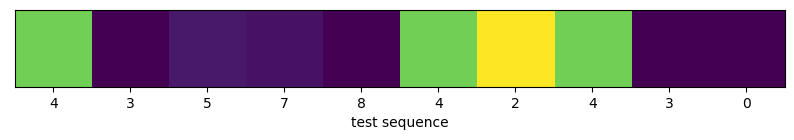

In [46]:
plt.figure(figsize=(10,1))
plt.imshow(attention[0].cpu().numpy())
plt.xticks(np.arange(10), x[0].cpu().numpy())
plt.yticks([])
plt.xlabel("test sequence")
plt.show()

Next we can take a look at the values.

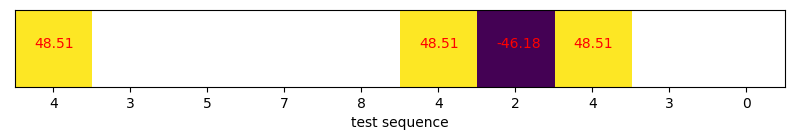

In [47]:
plt.figure(figsize=(10,1))
vals = values[0,:,:].T
vals[attention[0] < 0.1] = np.nan
plt.imshow(vals.cpu().numpy())
plt.xticks(np.arange(10), x[0].cpu().numpy())
plt.yticks([])
plt.xlabel("test sequence")
for i, v in enumerate(vals[0].cpu().numpy()):
    plt.text(i - 0.25, 0., "" if np.isnan(v) else f"{v:.2f}", c="red")
plt.show()

### Loading the data and preprocessing

We will use the same preprocessing as in the last tutorial.

In [ ]:
# ONLY when using Colab, execute the following lines
!wget -O ErUMData.zip https://www.dropbox.com/scl/fi/gvmelw7u619moo8nyg3j7/ErUMData.zip?rlkey=kq4do1fmalppjt2v24lzau4li&dl=1
!unzip -q ErUMData.zip 
!rm ErUMData.zip
path = ""

In [28]:
train_data = np.load(f"{path}dy_trn_data.npy")
val_data = np.load(f"{path}dy_val_data.npy")
test_data = np.load(f"{path}dy_tst_data.npy")

In [29]:
def apply_preprocessing(data_full):
    pt = np.sqrt(data_full[:,1]**2 + data_full[:,2]**2)
    eta1 = np.arctanh(data_full[:,3] / np.sqrt(data_full[:,1]**2 + data_full[:,2]**2 + data_full[:,3]**2))
    eta2 = np.arctanh(data_full[:,7] / np.sqrt(data_full[:,5]**2 + data_full[:,6]**2 + data_full[:,7]**2))
    phi1 = np.arctanh(np.arctan2(data_full[:,2], data_full[:,1]) / np.pi)
    return np.stack((pt, eta1, eta2, phi1), axis=1)
    
def invert_preprocessing(data_red):
    pt = data_red[...,0]
    eta1 = data_red[...,1]
    eta2 = data_red[...,2]
    phi1 = np.arctan(data_red[...,3]) * np.pi
    px1 = pt * np.cos(phi1)
    py1 = pt * np.sin(phi1)
    pz1 = pt * np.sinh(eta1)
    e1 = np.sqrt(px1**2 + py1**2 + pz1**2)
    px2 = -px1
    py2 = -py1
    pz2 = pt * np.sinh(eta2)
    e2 = np.sqrt(px2**2 + py2**2 + pz2**2)
    return np.stack((e1, px1, py1, pz1, e2, px2, py2, pz2), axis=-1)

def get_obs(event):
    jet1_4m = event[:,0:4]
    jet2_4m = event[:,4:]
    event_4m = jet1_4m + jet2_4m
    event_im = np.sqrt(event_4m[:,0]**2 - event_4m[:,1]**2 - event_4m[:,2]**2 - event_4m[:,3]**2)
    pt = np.sqrt(jet1_4m[:,1]**2 + jet1_4m[:,2]**2)
    return event_im, pt

In [30]:
train_data_preproc = apply_preprocessing(train_data)
train_mean = np.mean(train_data_preproc, axis=0)
train_std = np.std(train_data_preproc, axis=0)
train_data_normalized = torch.tensor((train_data_preproc - train_mean) / train_std, dtype=torch.float32)
train_dataset = TensorDataset(train_data_normalized)
train_dataloader = DataLoader(train_data_normalized, batch_size=1024, shuffle=True, generator=torch.Generator(device))

### Building a generative transformer step by step

In the following exercises, we will build a generative transformer for the Drell-Yan data set.

#### Exercise 2: Build the attention mask

To make the transformer autoregressive, we have to make sure that every generated feature is only dependent on the features before, but not itself or the following features. This can be achieved by setting some of the elements of the attention matrix to zero. We can pass a boolean tensor to the torch.TransformerEncoder to do this masking. Construct such a mask and put it in the function `attention_mask` function of the `JetGPT` class.

In [12]:
# Check here if your matrix looks correct before you put it into the JetGPT class

#### Exercise 3: Build the Gaussian mixture model

Finally, we need to define some distribution to calculate the likelihood of the training data. In contrast to language processing, we are not dealing with a discrete distribution. So we need some continuous distribution that is expressive enough to model the distribution of the data. There are different options to do this. In this example, we will use a Gaussian mixture model.

Pytorch provides the module `torch.distributions`. We can use it to construct a `Distribution` object that has functions to compute the log-likelihood and draw samples. Complete the function `gaussian_mixture_model` in the `JetGPT` class. The function first splits its argument into the means, standard deviations and relative magnitudes of the Gaussians. We use an exponential to ensure positive standard deviations and a softmax to ensure properly normalized magnitudes.

Hint: Use the classes `D.Categorical`, `D.Normal`, `D.MixtureSameFamily`.

In [13]:
# Make a plot of samples from your GMM here to see if it looks correct before you put it into the JetGPT class

#### Exercise 4: Build the embedding

The transformer can't operate on the training data directly. Instead, we have to embed it into the transformer embedding space. This space has to contain the information about the training feature itself and about its position, since the transformer by itself is permutation invariant. There are several options to build this embedding:
- Concatenate the feature and a one-hot encoded representation of the position. Then use a linear layer to map it into the embedding space.
- Map the feature into the embedding space using a linear layer and use torch.nn.Encoding for the position. Then add the two resulting vectors.
Choose one of these options (both should work fine) and implement it in the `embedding` function of the `JetGPT` class below.

In [37]:
class JetGPT(nn.Module):
    def __init__(
        self,
        data_dim: int,           # number of features in the data
        embedding_dim: int,      # number of features in the transformer
        heads: int,              # number of attention heads
        feedforward_dim: int,    # dimension of the feed-forward layers in the transformer
        transformer_layers: int, # number of transformer layers
        mlp_layers: int,         # number of layers in the final MLP
        mlp_hidden_dim: int,     # number of hidden nodes in the final MLP
        gaussians: int,          # number of Gaussians in the Gaussian mixture model
    ):
        super().__init__()
        self.data_dim = data_dim
        
        # Build trainable embedding layer
        self.embedding_layer = torch.nn.Linear(data_dim + 1, embedding_dim)

        # Build transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=heads,
            dim_feedforward=feedforward_dim,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=transformer_layers)

        # Build final MLP
        layers = []
        layer_dim_in = embedding_dim
        for i in range(mlp_layers - 1):
            layers.append(nn.Linear(layer_dim_in, mlp_hidden_dim))
            layers.append(nn.ReLU())
            layer_dim_in = mlp_hidden_dim
        layers.append(nn.Linear(layer_dim_in, gaussians * 3))
        self.mlp = nn.Sequential(*layers)

    def embedding(
        self,
        x: torch.Tensor, # input data, shape (n_batch, seq_len)
    ) -> torch.Tensor:   # returns data in embedding space, shape (n_batch, seq_len [+1], data_dim + 1)
        shifted_x = torch.cat((torch.zeros((x.shape[0], 1)), x), dim=1)
        embedding_input = torch.cat((
            shifted_x[:, :, None],
            torch.eye(shifted_x.shape[1], self.data_dim)[None, :, :].expand(x.shape[0], -1, -1)
        ), dim=2)
        return self.embedding_layer(embedding_input)
    
    def attention_mask(
        self,
        size: int      # Size of the attention mask
    ) -> torch.Tensor: # Boolean tensor, shape (size, size)
        return torch.ones((size, size)).triu(diagonal=1).bool()

    def eval_networks(
        self,
        embedding: torch.Tensor, # data in embedding space, shape (n_batch, seq_len [+1], data_dim + 1)
    ) -> torch.Tensor:           # parameters of the GMM, shape (n_batch, seq_len [+1], 3 * gaussians)
        transformer_output = self.transformer(embedding, self.attention_mask(embedding.shape[1]))
        return self.mlp(transformer_output)

    def gaussian_mixture_model(
        self,
        gmm_params: torch.Tensor, # parameters of the GMM, shape (n_batch, seq_len [+1], 3 * gaussians)
    ) -> D.Distribution:          # Distribution object encoding the GMM
        mu = gmm_params[:, :, 0 :: 3]
        sigma = torch.exp(gmm_params[:, :, 1 :: 3])
        weights = F.softmax(gmm_params[:, :, 2 :: 3], dim=2)
        mix = D.Categorical(weights)
        comp = D.Normal(mu, sigma)
        return D.MixtureSameFamily(mix, comp)

    def input_to_gmm(
        self,
        x: torch.Tensor, # input data, shape (n_batch, seq_len)
    ) -> D.Distribution: # Distribution object encoding the GMM
        embedding = self.embedding(x)
        gmm_params = self.eval_networks(embedding)
        return self.gaussian_mixture_model(gmm_params)

    def log_prob(
        self,
        x: torch.Tensor, # input data, shape (n_batch, data_dim)
    ) -> torch.Tensor:   # log-probabilities, shape (n_batch, )
        return self.input_to_gmm(x[:, :-1]).log_prob(x).sum(dim=1)

    def sample(
        self,
        n_samples: int, # number of samples
    ) -> torch.Tensor:  # sampled data, shape (n_samples, data_dim)
        x = torch.zeros((n_samples, 0))
        for i in range(self.data_dim):
            x_new = self.input_to_gmm(x).sample()[:, -1:]
            x = torch.cat((x, x_new), dim=1)
        return x

### Training the model

After solving exercises 2 to 4, you should be able to train your transformer network with the training loop provided below.

In [38]:
jet_gpt = JetGPT(
    data_dim = 4,
    embedding_dim = 64,
    heads = 4,
    feedforward_dim = 128,
    transformer_layers = 4,
    mlp_layers = 3,
    mlp_hidden_dim = 64,
    gaussians = 10,
)
optimizer = torch.optim.Adam(jet_gpt.parameters(), lr=3e-4) # https://twitter.com/karpathy/status/801621764144971776

for epoch in range(5):
    epoch_losses = []
    for batch, x in enumerate(train_dataloader):
        loss = -jet_gpt.log_prob(x).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    print(f"Epoch {epoch+1}: loss = {np.mean(epoch_losses)}")

Epoch 1: loss = 3.918399922946501
Epoch 2: loss = 3.6049537604024424
Epoch 3: loss = 3.567686498517821
Epoch 4: loss = 3.5480723871281867
Epoch 5: loss = 3.5365760846603553


### Generating samples

Now that we have a trained transformer, the last step is to draw samples from the learned distribution.

#### Exercise 5: Generating samples

Complete the `sample` function of the `JetGPT` class. This time you need to use the sample function of the `Distribution` object.

In [39]:
with torch.no_grad():
    sample = jet_gpt.sample(100000).cpu().numpy()
sample_pp = invert_preprocessing(sample * train_std + train_mean)
gen_event_im, gen_pt = get_obs(sample_pp)
test_event_im, test_pt = get_obs(test_data)

### Study the results

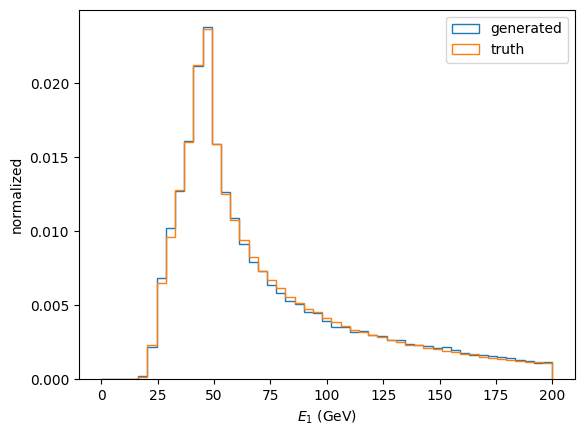

In [40]:
fig, axs = plt.subplots()

bins = np.linspace(0,200,50)
axs.hist(sample_pp[:,0], bins=bins, density=True, histtype="step", label="generated")
axs.hist(test_data[:,0], bins=bins, density=True, histtype="step", label="truth")

axs.set_xlabel("$E_1$ (GeV)")
axs.set_ylabel("normalized")
axs.legend()
plt.show()

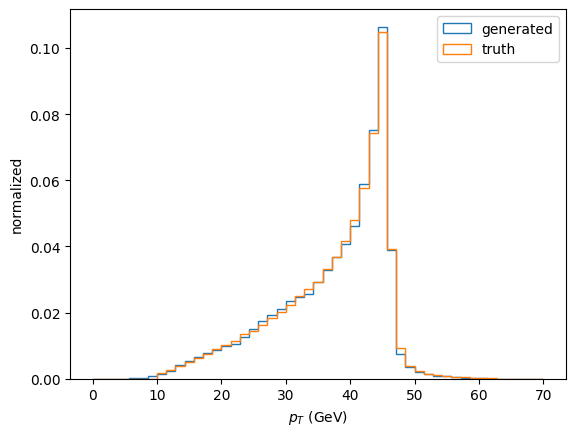

In [41]:
fig, axs = plt.subplots()

bins = np.linspace(0, 70, 50)
axs.hist(gen_pt, bins=bins, density=True, histtype="step", label="generated")
axs.hist(test_pt, bins=bins, density=True, histtype="step", label="truth")

axs.set_xlabel("$p_T$ (GeV)")
axs.set_ylabel("normalized")
axs.legend()
plt.show()

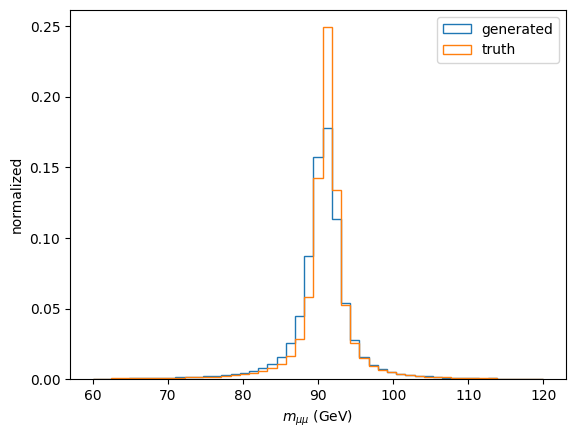

In [42]:
fig, axs = plt.subplots()

bins = np.linspace(60, 120, 50)
axs.hist(gen_event_im, bins=bins, density=True, histtype="step", label="generated")
axs.hist(test_event_im, bins=bins, density=True, histtype="step", label="truth")

axs.set_xlabel("$m_{\mu\mu}$ (GeV)")
axs.set_ylabel("normalized")
axs.legend()
plt.show()

### Bonus exercises

#### Exercise A

Make plots for some more observables, for example $\phi$ or $\eta$. Which ones are easy for the network and which ones are more difficult?

#### Exercise B

Play around with the hyperparameters of the network. Which ones have a large impact on the performance?

#### Exercise C

Since our generative transformer is autoregressive, it makes a difference which order we choose for the input features. Try a different ordering and see if it makes a difference.

#### Exercise D

We can even randomize the order of the components during the training and train the network for arbitrary orders. The positional encoding ensures that every component is in the right place in the end. Implement that for our JetGPT training.